In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from cycler import cycler
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import polyan

#define a reference profile based on a representative polysome experimental profile
ref_peaks = [0.003, 0.0051, 0.026, 0.018, 0.0205, 0.0155, 0.012, 0.0085, 0.008, 0.006, 0.005, 0.0035, 0.002, 0.0015, 0.001, 0.0005, 0.0002, 5e-05]
ref_peaks = ref_peaks/ np.sum(ref_peaks)
x_ref,y_ref = polyan.plot_poly(ref_peaks)

<a name='TOC'></a>
<h1>In this Notebook</h1>
<ul style="font-size:20px">
    <li><a href="#ribosome_densities">Origin of ribosome-dense transcripts</a></li>
    <li><a href="#correlation">Correlation of ribosome densities between datasets</a></li>
    <li><a href="#CHX">Comparison of cycloheximide concentrations</a></li>
    <li><a href="#libraries">Comparison of library preparation methods</a></li>
    <li><a href="#nucleases">Comparison of nuclease types</a></li>
</ul>

<a name="ribosome_densities"></a>
<h2>Origin of ribosome-dense transcripts</h2>
<p>This analysis traces the origin of highly ribosome-dense transcripts in a dataset showing aberrant high-polysome peaks. The reference and control dataset can be changed by setting the 'dataset' and 'con_dataset' variables in the next cell to other GEO identifiers for the yeast datasets in our list.</p>
<p><a href='#TOC'>Back to top.</a></p>

In [28]:
#prepare the standard polyan plot of the dataset
dataset = 'GSE108778'
ref_peaks = [0.003, 0.0051, 0.026, 0.018, 0.0205, 0.0155, 0.012, 0.0085, 0.008, 0.006, 0.005, 0.0035, 0.002, 0.0015, 0.001, 0.0005, 0.0002, 5e-05]
ref_peaks = ref_peaks/ np.sum(ref_peaks)
x_ref,y_ref = polyan.plot_poly(ref_peaks)
data_peaks = polyan.fp2poly(pd.read_csv('Data/'+dataset+'.csv', index_col=False))
x,y = polyan.plot_poly(data_peaks)

#prepare the standard polyan plot of the control dataset
con_dataset = 'GSE87614'
control_peaks = polyan.fp2poly(pd.read_csv('Data/'+con_dataset+'.csv', index_col=False))
con_x,con_y = polyan.plot_poly(control_peaks)

In [29]:
#reproduce the calculations used in generating the profile
#for the analysis dataset

#read in the dataset and combine with gene length data
data = pd.read_csv('Data/'+dataset+'.csv', index_col=False)
data = data.dropna(subset=['Ribo_Prints','RNA_Prints'])
genes = pd.read_csv('Data/SacCer3 genes.csv')
data = data.merge(genes[['name','length']], how = 'inner', left_on = 'ORF',right_on = 'name')
data = data[['ORF','RNA_Prints','Ribo_Prints','length']]

#calculate the ribosomes per mRNA (these calculations reproduce the polyan calculations exactly for the 'Scer' parameters)
data['RNA_RPK'] = data['RNA_Prints']/(data['length']/1000)
RiboPrints2Ribos = (200000 * 0.85) / sum(data['Ribo_Prints'])
data['Ribos_bound'] = data['Ribo_Prints'] * RiboPrints2Ribos
RNARPK2RNAs = 60000 / sum(data['RNA_RPK'])
data['RNAs_per_cell'] = data['RNA_RPK'] * RNARPK2RNAs
data['RperR'] = data['Ribos_bound'] / data['RNAs_per_cell']
data = data.dropna()
data = data.loc[data['RperR'] <= 30]
data = data.loc[data['RNAs_per_cell'] > 0.05]

#add color values to highlight genes between 8 and 10 ribosomes per RNA in red
data['color'] = 'black'
for row in range(data.shape[0]):
    if data.iloc[row]['RperR'] > 17:
        data.iloc[row,8] = 'red'

#reproduce the calculations used in generating the profile
#for the control dataset

#read in the control dataset and combine with gene length data and color indicators of the first dataset
con_data = pd.read_csv('Data/'+con_dataset+'.csv', index_col=False)
con_data = con_data.dropna(subset=['Ribo_Prints','RNA_Prints'])
con_data = con_data.merge(data[['ORF','length', 'color']], how = 'inner', on = 'ORF')
con_data = con_data[['ORF','RNA_Prints','Ribo_Prints','color','length']]
#calculate the ribosomes per mRNA (these calculations reproduce the polyan calculations exactly for the 'Scer' parameters)
con_data['RNA_RPK'] = con_data['RNA_Prints']/(con_data['length']/1000)
RiboPrints2Ribos = (200000 * 0.85) / sum(con_data['Ribo_Prints'])
con_data['Ribos_bound'] = con_data['Ribo_Prints'] * RiboPrints2Ribos
RNARPK2RNAs = 60000 / sum(con_data['RNA_RPK'])
con_data['RNAs_per_cell'] = con_data['RNA_RPK'] * RNARPK2RNAs
con_data['RperR'] = con_data['Ribos_bound'] / con_data['RNAs_per_cell']
con_data = con_data.dropna()
con_data = con_data.loc[con_data['RperR'] <= 30]
con_data = con_data.loc[con_data['RNAs_per_cell'] > 0.05]
#separate red and black datapoints to control plotting order
con_data_black = con_data.loc[con_data['color'] == 'black']
con_data_red = con_data.loc[con_data['color'] == 'red']

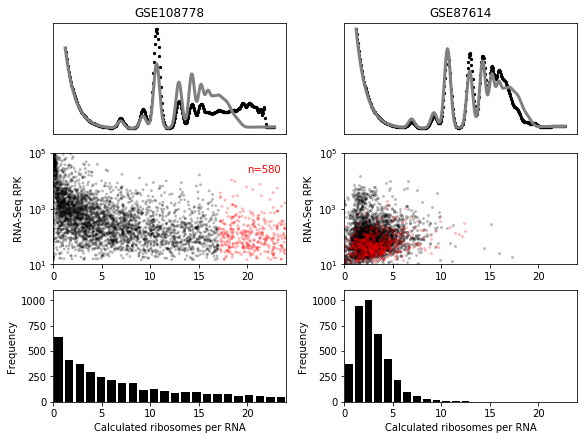

In [32]:
#plot results
fig,axs = plt.subplots(3,2,figsize = (8,6),constrained_layout = True)
axs[0,0].plot(x_ref,y_ref,c='grey',linewidth=3)
axs[0,0].scatter(x,y,c='black',s=5)
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_title(dataset)
axs[0,1].plot(x_ref,y_ref,c='grey',linewidth=3)
axs[0,1].scatter(con_x,con_y,c='black',s=5)
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].set_title(con_dataset)
axs[1,0].scatter(data['RperR'],data['RNA_RPK'],s=4,c=data['color'],alpha = 0.2)
axs[1,0].text(20,20000,'n=' + str(con_data_red.shape[0]),color='red')
axs[1,0].set_ylabel('RNA-Seq RPK')
axs[1,0].set_ylim((10,100000))
axs[1,0].set_yscale('log')
axs[1,0].set_xlim(0,24)
axs[1,1].scatter(con_data_black['RperR'],con_data_black['RNA_RPK'],s=4,c='black',alpha = 0.2)
axs[1,1].scatter(con_data_red['RperR'],con_data_red['RNA_RPK'],s=4,c='red',alpha = 0.2)
axs[1,1].set_ylabel('RNA-Seq RPK')
axs[1,1].set_ylim((10,100000))
axs[1,1].set_yscale('log')
axs[1,1].set_xlim(0,24)
axs[2,0].hist(data['RperR'],bins = 22,range=(0,24),rwidth = 0.8,color='black')
axs[2,0].set_xlim(0,24)
axs[2,0].set_ylim(0,1100)
axs[2,0].set_xlabel('Calculated ribosomes per RNA')
axs[2,0].set_ylabel('Frequency')
axs[2,1].hist(con_data['RperR'],bins = 24, range = (0,24), rwidth=0.8,color='black')
axs[2,1].set_xlim(0,24)
axs[2,1].set_ylim(0,1100)
axs[2,1].set_xlabel('Calculated ribosomes per RNA')
axs[2,1].set_ylabel('Frequency')
#plt.savefig('Extra_peak_tracing.svg')
plt.show()

<a name='correlation'></a>
<h2>Correlation of ribosome densities between datasets</h2>
<p>This analysis determines and plots the pairwise correlation of ribosome densities for all datasets analysed here.</p>
<p><a href='#TOC'>Back to top.</a></p>

In [24]:
#analyse how well ribosome densities correlate between datasets

#calculate the pairwise correlation coefficients for RperR data between datasets
RNA_ref = pd.read_csv('Data/sacCer3.csv')
RNA_ref = RNA_ref[['systematic','RNA_Prints','length']]
RNA_ref.columns = ['ORF','RNA_Prints','length']
datasets = pd.read_csv('Data/yeast_datasets.csv')
#reorder datasets in the order of the cluster names
datasets_ordered = datasets.sort_values(by='nrmsd')
datasets_ordered = datasets_ordered[['SeriesID','nrmsd']].reset_index(drop=True)

#remove existing results sets
if 'results' in locals():
    del(results)

for dataset in datasets_ordered['SeriesID']:
    #read in the dataset and combine with gene length data
    data = pd.read_csv('Data/'+dataset+'.csv')[['ORF','Ribo_Prints']]
    data = data.merge(RNA_ref,on='ORF',how='inner')
    data = data.dropna(subset=['Ribo_Prints','RNA_Prints'])

    #calculate the ribosomes per mRNA (these calculations reproduce the polyan calculations exactly for the 'Scer' parameters)
    data['RNA_RPK'] = data['RNA_Prints']/(data['length']/1000)
    RiboPrints2Ribos = (200000 * 0.85) / sum(data['Ribo_Prints'])
    data['Ribos_bound'] = data['Ribo_Prints'] * RiboPrints2Ribos
    RNARPK2RNAs = 60000 / sum(data['RNA_RPK'])
    data['RNAs_per_cell'] = data['RNA_RPK'] * RNARPK2RNAs
    data['RperR'] = data['Ribos_bound'] / data['RNAs_per_cell']
    data = data.dropna()
    #data = data.loc[data['RperR'] <= 30]
    data = data.loc[data['RNAs_per_cell'] > 0.05]
    data = data[['ORF','RperR']]
    data.columns = ['ORF',dataset]
    if not 'results' in locals():
        results = data
    else:
        results = results.merge(data, how = 'inner',on='ORF')

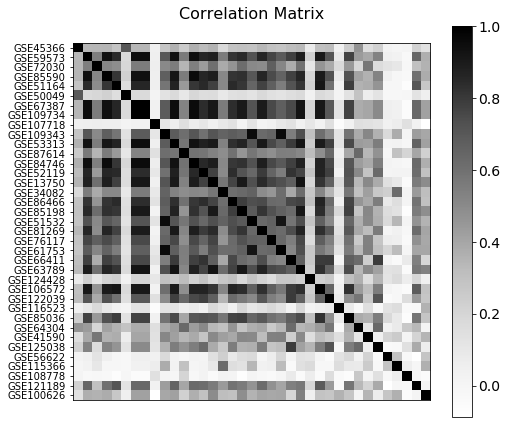

In [25]:
#plot results

f = plt.figure(figsize=(8, 7))
plt.matshow(results.corr(),cmap=cm.Greys,fignum=f.number)
plt.xticks(())
plt.yticks(range(results.select_dtypes(['number']).shape[1]), results.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.savefig('Correlation.svg')
plt.title('Correlation Matrix', fontsize=16);

<a name="CHX"></a>
<h2>Cycloheximide Series</h2>
<p>This analyses data generated by <a href="https://www.ncbi.nlm.nih.gov/pubmed/25056308" target=_blank>Gerashchenko and Gladyshev (2014)</a> using a cycloheximide concentration series. The dataset is <a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE59573" target=_Blank>GSE59573</a>. "1x CHX" refers to the standard final concentration of 100 &mu;g/ml.</p>
<p><a href='#TOC'>Back to top.</a></p>

In [7]:
#read in the CHX concentration series data and produce the peak information
poly_vols = []
all_dats = pd.read_csv('Data/GSE59573_all_CHX_concs.csv')
for col in range(1,all_dats.shape[1]):
    dats = all_dats.iloc[:,[0,col]]
    dats.columns = ['ORF','Ribo_Prints']
    poly_vols.append(polyan.fp2poly(dats, has_RNA = False))

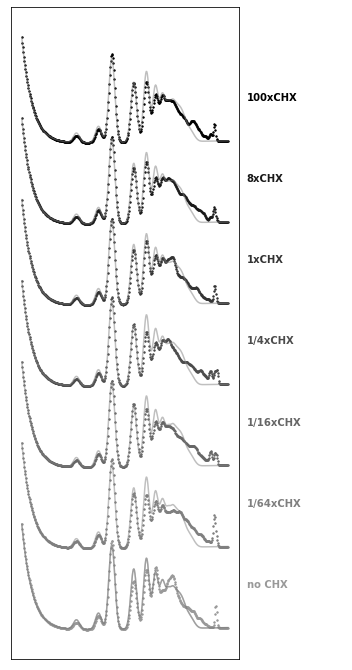

In [8]:
#plot the results
labels = list(all_dats.columns[1:])
labels = [l.replace('_','/') for l in labels]
labels = [l.replace('0/','no ') for l in labels]
colors=plt.cm.gist_yarg(np.linspace(0.4,1,len(poly_vols)))
fig,ax = plt.subplots(1,2,sharey=True,gridspec_kw={'width_ratios': [3, 1]},figsize = (6,12))
ax[0].set_prop_cycle(cycler(color=colors))
ax[0].plot(x_ref,y_ref,c='grey', label='experimental',alpha = 0.5)
offset_by = 5
offset = 0
for trace_no in range(len(poly_vols)):    
    ax[0].plot(x_ref,y_ref+offset ,c='grey', label='experimental',alpha = 0.5)    
    x,y = polyan.plot_poly(poly_vols[trace_no])
    ax[0].scatter(x,y+offset,s=2,label = labels[trace_no])
    ax[1].text(-0.3,offset+max(y_ref[20:])/2,labels[trace_no],color = colors[trace_no],
              fontdict={'weight':'bold'})
    offset += offset_by
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].axis('off')
#plt.savefig('CHX_series.svg')
plt.show()

<a name="libraries"></a>
<h2>Library preparation protocols</h2>
<p>This analyses data from <a href="https://www.ncbi.nlm.nih.gov/pubmed/27450428" target=_blank>Lecanda <i>et al.</i> (2016).</a> which tests a variety of library preparation protocols. The dataset used is <a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE84746" target=_blank>GSE84746</a>.</p>
<p><a href='#TOC'>Back to top.</a></p>

In [9]:
#analysis of library prep series
poly_vols = []
for file in ['GSE84746_DualLigation.csv','GSE84746_3N.csv',
             'GSE84746_4N.csv','GSE84746_4N_low.csv',
             'GSE84746_nonrand.csv','GSE84746_nonrand_low.csv']:
    dats = pd.read_csv('Data/' + file)[['ORF','Ribo_Prints']]
    poly_vols.append(polyan.fp2poly(dats,has_RNA=False))
    

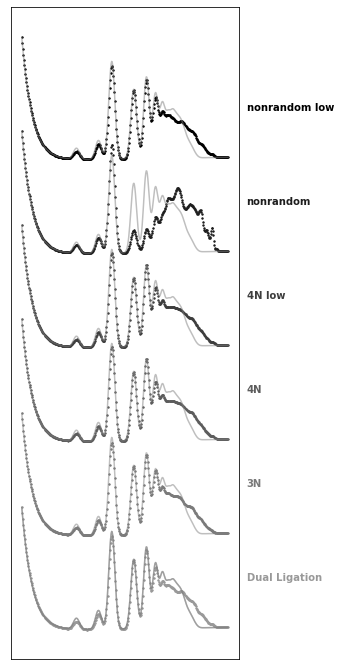

In [10]:
#plot the results
labels = ['Dual Ligation','3N','4N','4N low','nonrandom','nonrandom low']
colors=plt.cm.gist_yarg(np.linspace(0.4,1,len(poly_vols)))
fig,ax = plt.subplots(1,2,sharey=True,gridspec_kw={'width_ratios': [3, 1]},figsize = (6,12))
ax[0].set_prop_cycle(cycler(color=colors))
ax[0].plot(x_ref,y_ref,c='grey', label='experimental',alpha = 0.5)
offset_by = 5
offset = 0
for trace_no in range(len(poly_vols)):    
    ax[0].plot(x_ref,y_ref+offset ,c='grey', label='experimental',alpha = 0.5)    
    x,y = polyan.plot_poly(poly_vols[trace_no])
    ax[0].scatter(x,y+offset,s=2,label = labels[trace_no])
    ax[1].text(-0.3,offset+max(y_ref[20:])/2,labels[trace_no],color = colors[trace_no],
              fontdict={'weight':'bold'})
    offset += offset_by
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].axis('off')
#plt.savefig('library_series.svg')
plt.show()

<a name="nucleases"></a>
<h2>Nuclease series</h2>
<p>This analyses data from <a href='https://pubmed.ncbi.nlm.nih.gov/27638886/' target=_blank>Gerashchenko and Galdyshev</a> (2017) which compares the use of different nucleases in the preparation of ribosome protected fragments. The dataset used is <a href='https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE82220' target=_blank>GSE82220</a>.
<p><a href='#TOC'>Back to top.</a></p>

In [11]:
#read in the nuclease concentration series data and produce the peak information
poly_vols = []
all_dats = pd.read_csv('Data/GSE82220_all_yeast_data.csv')
#average the two repeats for nuclease I
all_dats['I'] = all_dats[['I.1','I.2']].mean(axis=1)
all_dats = all_dats[['gene','S7','A','T1','I']]
#remove rows summarising reads mapped to multiple genes, 
#which are indicated by gene descriptors like 'gene1_gene2'
all_dats = all_dats[all_dats['gene'].map(lambda x: '_' not in str(x))]
#calculate the peak volumes
for col in range(1,all_dats.shape[1]):
    dats = all_dats.iloc[:,[0,col]]
    dats.columns = ['ORF','Ribo_Prints']
    poly_vols.append(polyan.fp2poly(dats, has_RNA = False))

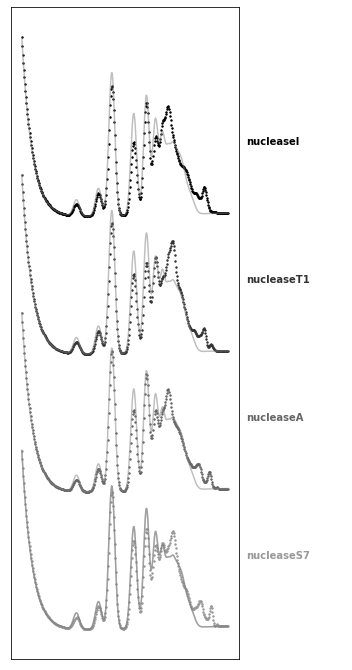

In [12]:
#plot the results
labels = ['nuclease' + nuc for nuc in all_dats.columns[1:]]
#labels = [l.replace('_','/') for l in labels]
#labels = [l.replace('0/','no ') for l in labels]
colors=plt.cm.gist_yarg(np.linspace(0.4,1,len(poly_vols)))
fig,ax = plt.subplots(1,2,sharey=True,gridspec_kw={'width_ratios': [3, 1]},figsize = (6,12))
ax[0].set_prop_cycle(cycler(color=colors))
ax[0].plot(x_ref,y_ref,c='grey', label='experimental',alpha = 0.5)
offset_by = 5
offset = 0
for trace_no in range(len(poly_vols)):    
    ax[0].plot(x_ref,y_ref+offset ,c='grey', label='experimental',alpha = 0.5)    
    x,y = polyan.plot_poly(poly_vols[trace_no])
    ax[0].scatter(x,y+offset,s=2,label = labels[trace_no])
    ax[1].text(-0.3,offset+max(y_ref[20:])/2,labels[trace_no],color = colors[trace_no],
              fontdict={'weight':'bold'})
    offset += offset_by
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].axis('off')
#plt.savefig('nuclease_series.svg')
plt.show()

<a href='#TOC'>Back to top.</a>